In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from skimage.color import gray2rgb
import shap
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import img_to_array


In [ ]:

# Load the FashionMNIST dataset
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

# Preprocess the data
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Define the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']



In [7]:

# Select two examples
example1_idx = np.argmax(y_test == 0)
example2_idx = np.argmax(y_test == 1)

example1 = X_test[example1_idx]
example2 = X_test[example2_idx]

# Convert grayscale image to RGB
example2_rgb = gray2rgb(example2.reshape(28, 28))

# Make predictions for the examples
example1_pred = model.predict(example1.reshape(1, 28, 28, 1))
example2_pred = model.predict(example2.reshape(1, 28, 28, 1))

# Get the predicted classes and probabilities
example1_class = np.argmax(example1_pred)
example1_prob = example1_pred[0, example1_class]
example1_second_prob = np.sort(example1_pred)[0, -2]
example1_least_prob = np.sort(example1_pred)[0, -1]

example2_class = np.argmax(example2_pred)
example2_prob = example2_pred[0, example2_class]
example2_second_prob = np.sort(example2_pred)[0, -2]
example2_least_prob = np.sort(example2_pred)[0, -1]

print(f"Example 1: True Class - {class_names[0]}")
print(f"           Predicted Class - {class_names[example1_class]}")
print(f"           Probability - {example1_prob:.4f}")
print(f"           Second Most Likely Probability - {example1_second_prob:.4f}")
print(f"           Least Likely Probability - {example1_least_prob:.4f}")
print()
print(f"Example 2: True Class - {class_names[1]}")
print(f"           Predicted Class - {class_names[example2_class]}")
print(f"           Probability - {example2_prob:.4f}")
print(f"           Second Most Likely Probability - {example2_second_prob:.4f}")
print(f"           Least Likely Probability - {example2_least_prob:.4f}")
print()




1/1 [==============================] - 0s 15ms/step
Example 1: True Class - T-shirt/top
           Predicted Class - T-shirt/top
           Probability - 0.8014
           Second Most Likely Probability - 0.1943
           Least Likely Probability - 0.8014

Example 2: True Class - Trouser
           Predicted Class - Trouser
           Probability - 1.0000
           Second Most Likely Probability - 0.0000
           Least Likely Probability - 1.0000



In [8]:
# Adversarial attack using FGSM

# Set the epsilon value for FGSM
epsilon = 0.1

# Convert the examples to tensors
example1_tensor = tf.convert_to_tensor(example1.reshape(1, 28, 28, 1), dtype=tf.float32)
example2_tensor = tf.convert_to_tensor(example2.reshape(1, 28, 28, 1), dtype=tf.float32)

# Use persistent gradient tape to compute gradients
with tf.GradientTape(persistent=True) as tape:
    tape.watch(example1_tensor)
    tape.watch(example2_tensor)

    # Compute the loss for the original examples
    original_loss1 = tf.keras.losses.sparse_categorical_crossentropy(y_test[example1_idx], model(example1_tensor))
    original_loss2 = tf.keras.losses.sparse_categorical_crossentropy(y_test[example2_idx], model(example2_tensor))

# Compute the gradients of the loss with respect to the input examples
gradient1 = tape.gradient(original_loss1, example1_tensor)
gradient2 = tape.gradient(original_loss2, example2_tensor)

# Generate the adversarial examples
perturbed_example1 = example1_tensor + epsilon * tf.sign(gradient1)
perturbed_example2 = example2_tensor + epsilon * tf.sign(gradient2)



In [9]:
# Get the predicted classes and probabilities for the adversarial examples
perturbed_example1_pred = model.predict(perturbed_example1)
perturbed_example2_pred = model.predict(perturbed_example2)

perturbed_example1_class = np.argmax(perturbed_example1_pred)
perturbed_example1_prob = perturbed_example1_pred[0, perturbed_example1_class]

perturbed_example2_class = np.argmax(perturbed_example2_pred)
perturbed_example2_prob = perturbed_example2_pred[0, perturbed_example2_class]

print("Adversarial Examples (FGSM):")
print(f"Example 1: Predicted Class - {class_names[perturbed_example1_class]}")
print(f"           Probability - {perturbed_example1_prob:.4f}")
print()
print(f"Example 2: Predicted Class - {class_names[perturbed_example2_class]}")
print(f"           Probability - {perturbed_example2_prob:.4f}")
print()


1/1 [==============================] - 0s 15ms/step
Adversarial Examples (FGSM):
Example 1: Predicted Class - Pullover
           Probability - 0.9606

Example 2: Predicted Class - Dress
           Probability - 0.9935



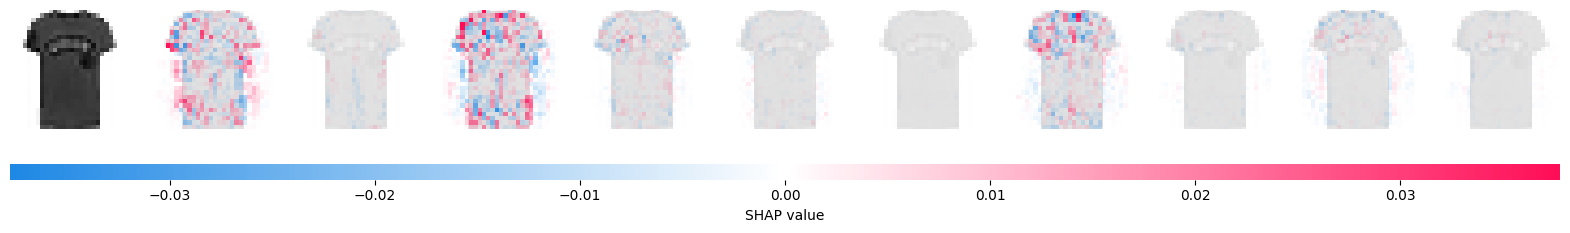

In [10]:
# SHAP Explanation
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(example1.reshape(1, 28, 28, 1))
shap.image_plot(shap_values, -example1.reshape(1, 28, 28, 1))


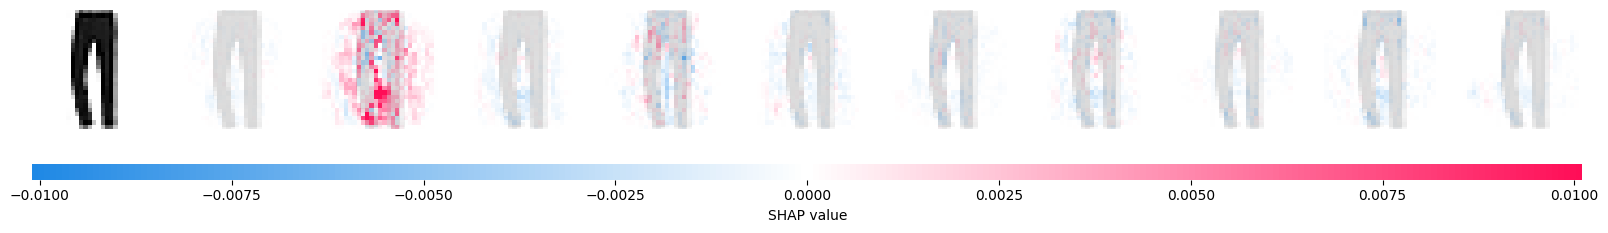

In [11]:
# DeepLIFT Explanation
explainer = shap.DeepExplainer(model, background)
deeplift_values = explainer.shap_values(example2.reshape(1, 28, 28, 1))
shap.image_plot(deeplift_values, -example2.reshape(1, 28, 28, 1))




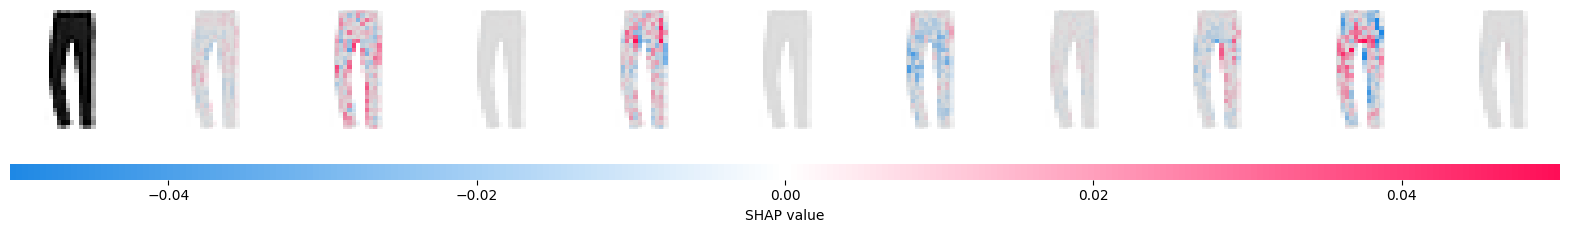

In [12]:


# Integrated Gradients Explanation
baseline = np.zeros_like(example2).reshape(1, 28, 28, 1)
explainer = shap.GradientExplainer(model, baseline)
shap_values = explainer.shap_values(example2.reshape(1, 28, 28, 1))
shap.image_plot(shap_values, -example2.reshape(1, 28, 28, 1))
